# Deep Learning Project

### Module installation for Google colab

In [20]:
!pip3 install --no-cache-dir -I pillow
!pip install --no-cache-dir -I pillow
!pip freeze

    100% |████████████████████████████████| 2.0MB 32.1MB/s 


In [41]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [6]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip3 install torchtext
!pip3 install torchvision

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    
    #os.unlink(zip_path)

### Check data upload

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

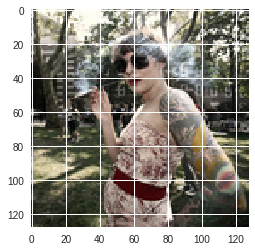

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('train/images/im1.jpg')

plt.imshow(img);

### Function to plot the image form a input tensor

In [0]:
def plot_image(tensor):
  
  if tensor.shape[0] == 3:

    x = tensor.permute(1,2,0).data.numpy()

    plt.imshow(x)
    
  elif tensor.shape[0] == 1:
    
    x = tensor.permute(1,2,0).squeeze(2).data.numpy()

    plt.imshow(x, cmap='gray')

In [0]:
def show_dataset(dataset, n=6):
    imgs = torch.stack([dataset[i][0] for _ in range(n)
                       for i in range(len(dataset))])
    
    for img in imgs:
      plot_image(img)

### Function to create the csv for associate to the image the labels contain in the folder "annotation"

In [47]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np


file_col=listdir("train/images")
list1 = [int(x[2:len(x)-4]) for x in file_col]
list1.sort()
listfin=["train/images/im"+str(num)+".jpg" for num in list1]

file_col=pd.Series(listfin)

df=pd.DataFrame()
df["fileName"]=file_col

path = "train/annotations"

row = 0

file_dic = {}

for label, filename in enumerate(listdir(path)):
  tmp=np.zeros(file_col.shape[0])
  with open(path+"/"+filename, "r") as file:
    file_len = 0
    for line in file:
      line = line.replace("\n", "")
      line = int(line)
      tmp[line-1] = 1
      file_len = file_len + 1
  tmp=pd.Series(tmp)
  df[filename]=tmp
  file_dic[filename] = file_len

print(file_dic)


{'bird.txt': 360, 'baby.txt': 95, 'flower.txt': 761, 'clouds.txt': 1095, 'sea.txt': 173, 'male.txt': 2979, 'female.txt': 3227, 'river.txt': 120, 'people.txt': 6403, 'car.txt': 319, 'portrait.txt': 3121, 'dog.txt': 448, 'tree.txt': 525, 'night.txt': 598}


In [48]:
df.head()

,fileName,bird.txt,baby.txt,flower.txt,clouds.txt,sea.txt,male.txt,female.txt,river.txt,people.txt,car.txt,portrait.txt,dog.txt,tree.txt,night.txt
0,train/images/im1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,train/images/im2.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train/images/im3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train/images/im4.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,train/images/im5.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df.loc[19998]

fileName        train/images/im19999.jpg
bird.txt                               0
baby.txt                               0
flower.txt                             0
clouds.txt                             0
sea.txt                                0
male.txt                               0
female.txt                             1
river.txt                              0
people.txt                             1
car.txt                                0
portrait.txt                           1
dog.txt                                0
tree.txt                               0
night.txt                              0
Name: 19998, dtype: object

### Given the csv that maps file and labels, create the pytorch data loader

In [0]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import operator

class ImageDataLoader(Dataset):
  def __init__(self,dataframe, transformations=None):
    
    # transformations
    self.to_tensor = transforms.ToTensor()
    self.to_grayscale = transforms.Grayscale()
    
    self.data_info = dataframe
    
    # First col is the path of the image
    self.image_arr = np.asarray(self.data_info.iloc[:,0])
    
    # Other cols are labels
    self.label_arr = np.asarray(self.data_info.iloc[:,range(1,self.data_info.shape[1])])
    
    # Len
    self.data_len = len(self.data_info.index)
    
    # for data augmentation
    self.transformations = transformations
    
   
  
  def __getitem__(self, index):
    
    # Get image name from the pandas df
    single_image_name = self.image_arr[index]
    
    # Open image
    img_as_img = Image.open(single_image_name)
    
    # Transform to gray
    img_as_img = self.to_grayscale(img_as_img)
    
    if self.transformations:
      img_as_img = self.transformations(img_as_img)
    
    # Transform image to tensor
    img_as_tensor = self.to_tensor(img_as_img)
      
    
    # if img_as_tensor.shape[0] == 1:
      # img_as_tensor

    # Get label(class) of the image based on the cropped pandas column
    single_image_label = self.label_arr[index]

    return (img_as_tensor, single_image_label)
  
  def __len__(self):
    return self.data_len
  
  def count_images(self):
    count = 0
    for i in self.image_arr:
      image= Image.open(i)
      img_as_tensor = self.to_tensor(image)
      # print(img_as_tensor.shape)
      if img_as_tensor.shape[0] == 1:
          count = count + 1
    print("gray scale:", count)
    print("coloured", len(self.image_arr)-count)
    
    

In [86]:
image_loader=ImageDataLoader(df)
image_loader.count_images()

gray scale: 1422
coloured 18578


In [51]:
dataloader = torch.utils.data.DataLoader(image_loader, batch_size=4, shuffle=True, num_workers=4)

for (batch_idx,batch) in enumerate(dataloader):
  
  _input, target = batch # input is a 3d tensor, target is 1d
  print(_input.shape)
  print(target.shape)
  # bs, ncrops, c, h, w = _input.size()
  # result = model(_input.view(-1, c, h, w)) # fuse batch size and ncrops
  
  # print(result)
  # result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops

torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 12

Process Process-40:
Process Process-39:
Process Process-38:
Process Process-37:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*s

torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])
torch.Size([4, 1, 128, 128])
torch.Size([4, 14])


  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 899, in convert
    self.load()
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 2609, in open
    fp = builtins.open(filename, "rb")
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFile.py", line 239, in load
    n, err_code = decoder.decode(b)
  File "/usr/local/lib/python3.6/dist-packages/PIL/ImageFile.py", line 239, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 110, in _worker_loop
    data_queue.put((idx, samples))
KeyboardInterrupt


RuntimeError: ignored

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 39, in __init__
    super().__init__(*args)


In [0]:
tfs = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
])

image_loader = ImageDataLoader(df, tfs)

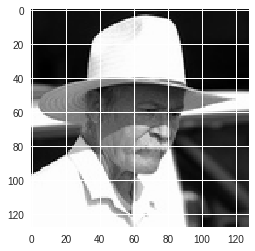

In [54]:
dataloader = torch.utils.data.DataLoader(image_loader, batch_size=4, shuffle=True, num_workers=4)

for (batch_idx,batch) in enumerate(dataloader):
  
  _input, target = batch # input is a 3d tensor, target is 1
  # plt.clf()
  plot_image(_input[0])
  if batch_idx == 4:
    break

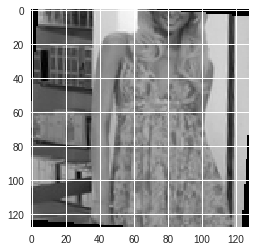

In [58]:
#to plot the immage
plot_image(image_loader.__getitem__(19998)[0])
# image_loader.__getitem__(19998)[0].shape

In [70]:
# to get the tensor associated to the image
image_loader.__getitem__(19998)[0][0][20]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2588, 0.2392, 0.2078, 0.2902, 0.0902, 0.0196, 0.0157,
        0.0118, 0.1490, 0.2706, 0.2667, 0.2392, 0.2784, 0.3725, 0.2980, 0.2235,
        0.2314, 0.3569, 0.3765, 0.2039, 0.2275, 0.2745, 0.3216, 0.3255, 0.3569,
        0.3686, 0.3412, 0.2745, 0.2667, 0.2941, 0.2980, 0.2588, 0.2118, 0.2431,
        0.3294, 0.5373, 0.6745, 0.6863, 0.6980, 0.5922, 0.4510, 0.4627, 0.4510,
        0.4588, 0.4588, 0.4706, 0.4863, 0.4980, 0.4980, 0.4902, 0.4824, 0.4745,
        0.4706, 0.4627, 0.4549, 0.4314, 0.3843, 0.4784, 0.5569, 0.5608, 0.5373,
        0.4863, 0.4863, 0.5333, 0.4941, 0.4588, 0.4941, 0.4980, 0.4627, 0.4706,
        0.5059, 0.4392, 0.4392, 0.4980, 0.5137, 0.5529, 0.5216, 0.3922, 0.2510,
        0.2275, 0.2078, 0.1922, 0.1961, 0.2353, 0.2824, 0.3176, 0.3098, 0.2627,
        0.1922, 0.1451, 0.2000, 0.2471, 0.2314, 0.2549, 0.2667, 0.3137, 0.3333,
        0.3373, 0.3020, 0.4667, 0.5647, 

In [71]:
#to get the lable asscoated to the image
image_loader.__getitem__(19998)[1]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.])